In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")

# read consensus, not noise, switches
switches <- read_tsv("../data/pancancer/candidateList_info.agg.tsv") %>%
    filter(NotNoise==1 & IsModel==1)
switches.full <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(IsModel==1 & NotNoise==1) %>%
    arrange(desc(PatientNumber))

# read mutations
wes <- read_tsv("../data/mutations/wes_mutations.txt") %>%
    select(Tumor,Gene,Symbol,Patient) %>%
    unique

wgs <- read_tsv("../data/mutations/wgs_mutations.txt") %>%
    select(Tumor,Gene,Symbol,Patient) %>%
    unique


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Some stats about switches

In [2]:
# num switches
nrow(switches)

# num genes
nrow(unique(switches[,c('GeneId','Symbol')]))

[1] 11019

[1] 7956

In [3]:
# Numbers
cdsNormal <- as.logical(switches$CDS_Normal)
cdsTumor <- as.logical(switches$CDS_Tumor)
functional <- as.logical(switches$IsFunctional)

# two protein coding isoforms
sum(cdsNormal & cdsTumor)

# only normal isoform
sum(cdsNormal & !cdsTumor)

# only tumor isoform
sum(!cdsNormal & cdsTumor)

# Percentages
# two protein coding isoforms
sum(cdsNormal & cdsTumor)/nrow(switches) * 100

# only normal isoform
sum(cdsNormal & !cdsTumor)/nrow(switches) * 100

# only tumor isoform
sum(!cdsNormal & cdsTumor)/nrow(switches) * 100

[1] 9444

[1] 1016

[1] 287

[1] 85.70651

[1] 9.220437

[1] 2.604592

In [4]:
# two protein coding isoforms
# functional
# number
sum(cdsNormal & cdsTumor & functional)
# percentage
sum(cdsNormal & cdsTumor & functional)/sum(cdsNormal & cdsTumor) * 100

[1] 7235

[1] 76.60949

In [5]:
# unbalance between only niso and only tiso
x <- sum(cdsNormal & !cdsTumor)
n <- sum(!cdsNormal & cdsTumor)+sum(cdsNormal & !cdsTumor)
binom.test(x,n,0.5)


	Exact binomial test

data:  x and n
number of successes = 1016, number of trials = 1303, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.7562355 0.8019735
sample estimates:
probability of success 
             0.7797391 


## Stats about patient recurrence
We will use mutation data to put switch data into context.

In [6]:
# count number of genes with
## WES mutation
genesPAM <- wes %>%
    group_by(Tumor,Patient) %>%
    summarise(PAM=length(Patient))

## WGS mutation
genesMutated <- wgs %>%
    group_by(Tumor,Patient) %>%
    summarise(Mutation=length(Patient))

## a functional switch
genesSwitched <- as.data.frame(table(unlist(strsplit(switches$Patients_affected[switches$IsFunctional==1],",")))) %>%
    set_colnames(c("Patient","Switch"))

# use number of spliced genes and total number of genes to normalize the observations
lines <- "Tumor\tSplicedGenes\tGenes\nbrca\t12383\t20530\nprad\t11849\t20530\nthca\t11812\t20530\ncoad\t11498\t20530\nhnsc\t11583\t20530\nkich\t11607\t20530\nkirc\t12205\t20530\nkirp\t11853\t20530\nlihc\t10490\t20530\nluad\t12046\t20530\nlusc\t12070\t20530\n"
consideredGenes <- read_tsv(lines) %>%
    set_colnames(c("Tumor","SplicedGenes","Genes"))

recurrence <- merge(genesSwitched,genesPAM,all=T) %>%
    merge(genesMutated,all=T) %>%
    merge(consideredGenes) %>%
    mutate(PAM=PAM/Genes, Mutation=Mutation/Genes,
           Switch=Switch/SplicedGenes) %>%
    select(everything(),-contains("Genes"))

Using Tumor, Patient as id variables
Warning message:
: Removed 4531 rows containing non-finite values (stat_boxplot).

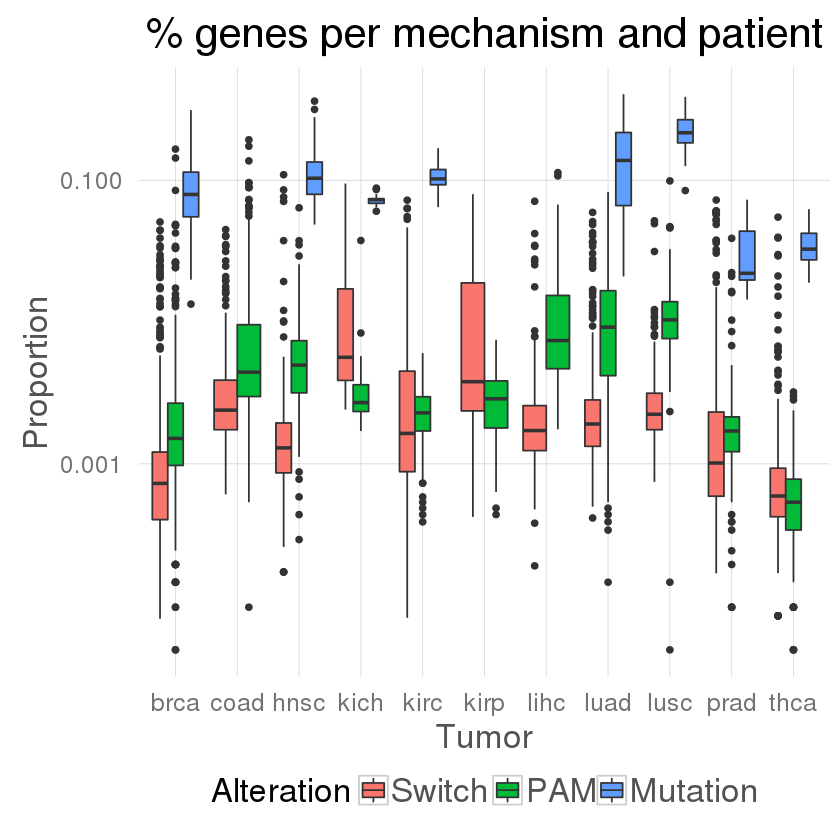

In [7]:
# show distribution of genes affected through each mechanism per patient
recurrence %>%
    melt %>%
    set_colnames(c("Tumor","Patient","Alteration","Proportion")) %>%
    ggplot(aes(x=Tumor,y=Proportion, fill=Alteration)) +
    geom_boxplot() + 
    smartas_theme() +
    scale_y_log10() +
    theme(legend.position="bottom") +
    labs(title="% genes per mechanism and patient")

Warning message:
: Removed 470 rows containing missing values (geom_point).

[1] -0.003499958

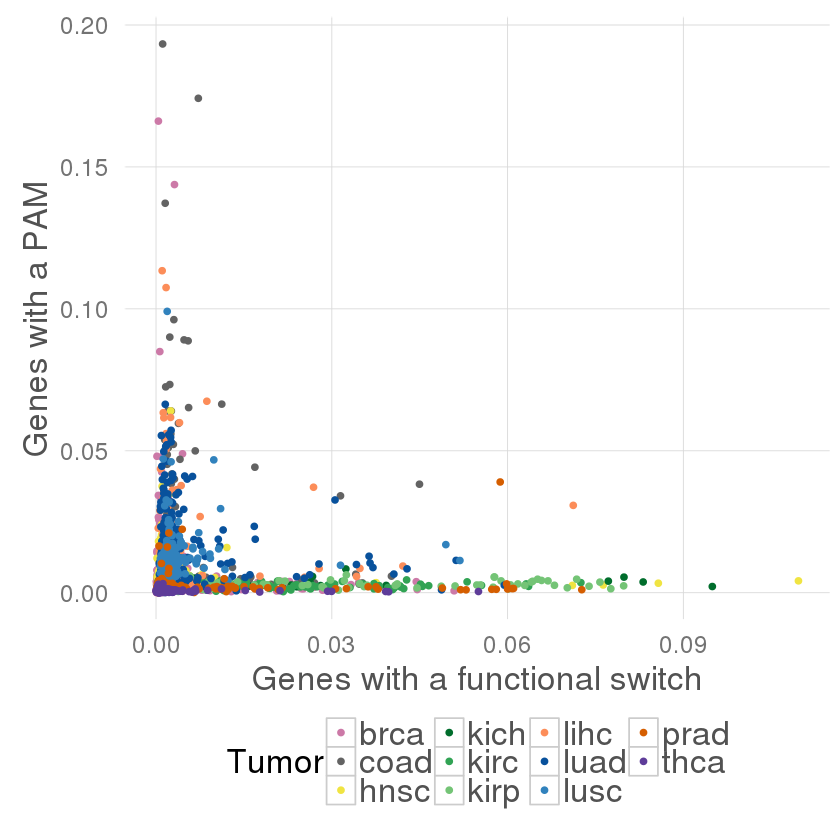

In [8]:
# show lack of correlation between mutations and switches
recurrence %>%
    ggplot(aes(x=Switch,y=PAM)) + 
    geom_point(aes(color=Tumor)) + 
    smartas_theme() +
    scale_color_manual(values=colorPalette) + 
    theme(legend.position="bottom") +
    labs(x="Genes with a functional switch", y="Genes with a PAM")

cor(recurrence$PAM, recurrence$Switch, use="complete.obs")

Warning message:
: Removed 470 rows containing non-finite values (stat_smooth).Warning message:
: Removed 470 rows containing missing values (geom_point).

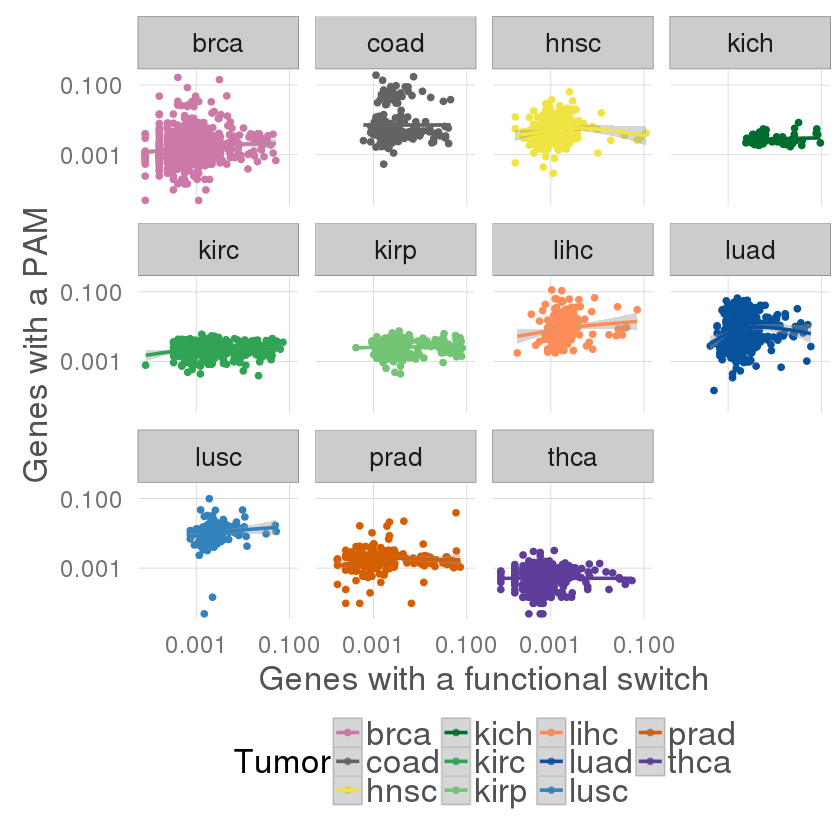

In [9]:
recurrence %>%
    ggplot(aes(x=Switch,y=PAM,color=Tumor)) + 
    geom_point() + 
    geom_smooth() +
    smartas_theme() +
    scale_y_log10() +
    scale_x_log10() +
    scale_color_manual(values=colorPalette) + 
    theme(legend.position="bottom") +
    labs(x="Genes with a functional switch", y="Genes with a PAM") + 
    facet_wrap(~ Tumor)

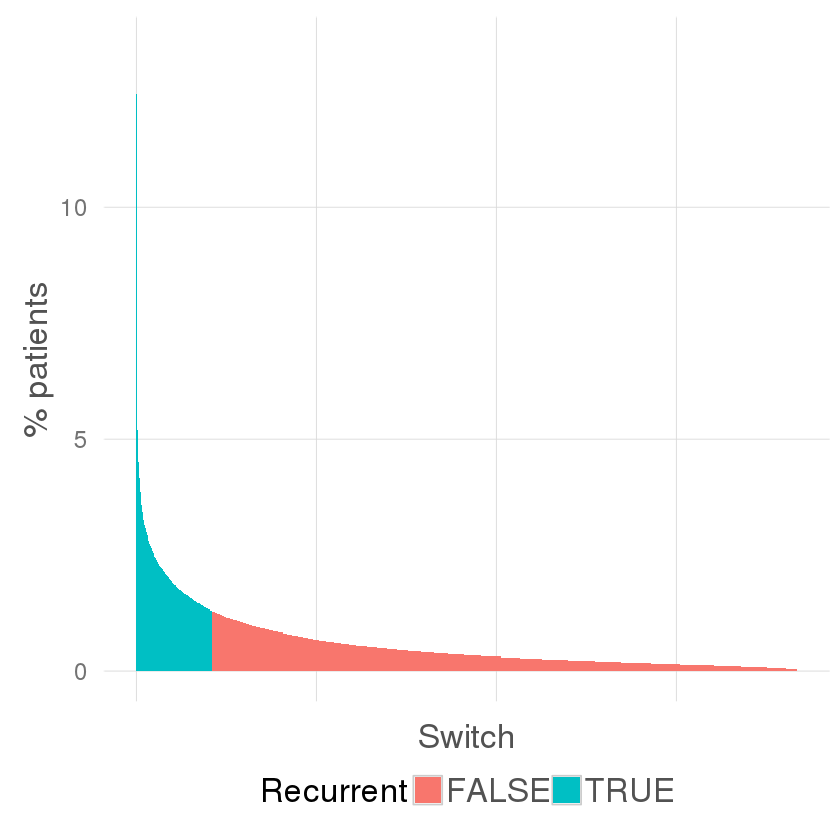

In [10]:
switches.full %>%
    mutate(.,Order=1:nrow(.),
          Recurrent=padj.recurrence < 0.05) %>%
    ggplot() +
    geom_area(aes(x=Order,y=100*PatientNumber/nPatients$total,fill=Recurrent)) +
    smartas_theme() + 
    theme(axis.text.x=element_blank(), legend.position="bottom") +
    labs(x="Switch",y="% patients")

## Stats about co-ocurrence

In [11]:
# number of functional switches with co-occurrence
sum(switches.full$p.mut.o < 0.05[switches.full$IsFuctional==1], na.rm=T)

# number of switches with co-occurrence
sum(switches.full$p.mut.o < 0.05, na.rm=T)
sum(switches.full$p.mut.o < 0.05, na.rm=T)/nrow(switches.full)*100

[1] 0

[1] 31

[1] 0.2813322